In [23]:
def last_weekday(d, weekday):
    days_behind = (-d.weekday()+weekday-7)%7
    return d+datetime.timedelta(days_behind)

In [24]:
import datetime
import matplotlib.pyplot as plt
import csv
import datetime
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image, sequence


def CreateDataset(start_day, end_day):
    years=[]
    months=[]
    days=[]
    with open('data-d1p8Q.csv') as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        next(csvReader)
        for row in csvReader:
            years.append(datetime.datetime.strptime(row[4],'%m/%d/%Y').strftime("%Y"))
            months.append(datetime.datetime.strptime(row[4],'%m/%d/%Y').strftime("%m"))
            days.append(datetime.datetime.strptime(row[4],'%m/%d/%Y').strftime("%d"))

    img_list=[]
    date=start_day #datetime.date(2014,1,7)
    positive_maps=[]
    fire_result=[]
    for i in range(len(days)):
        d = datetime.date(int(years[i]), int(months[i]), int(days[i]))
        next_tuesday=last_weekday(d, 1)# 0 = Monday, 1=Tuesday, 2=Wednesday...
        if next_tuesday not in positive_maps:
            positive_maps.append(next_tuesday) 
    while date<end_day: #datetime.date(2018,1,3):
        img_list.append('C:\\Users\\alpst\\Box Sync\\PhD\\fire\\'+ date.strftime("%Y%m%d")+".jpg")
        if date in positive_maps: 
            fire_result.append(1)
        else:
            fire_result.append(0)
        date=date+datetime.timedelta(days=7)
    
    labels=fire_result
   
    image_array=[]
    sequences_path_array=[]
    sequences_labels=[]

    for i in range(len(img_list)):

        image_array.append(plt.imread(img_list[i]))
        
       # for j in range(len(image_array)-history_size):
            #sequences_path_array.append(img_list[j:j+history_size])
            #sequences_labels.append(fire_result[j+history_size]

    train_path, test_path, train_y, test_y =  train_test_split(img_list,fire_result, test_size=0.20, random_state=10)
    train_path, valid_path, train_y, valid_y = train_test_split(train_path, train_y, test_size=0.20, random_state=10)

    return train_path,valid_path, test_path,\
           train_y, valid_y, test_y,\
            image_array, img_list, labels #, sequence_path_array, sequence_labels

In [25]:
def image_loader(images,image_array, figure_shape,to_norm = True):
    output_images = []
    mean_images=(np.mean(np.array(image_array), axis=tuple(range(np.array(image_array).ndim-1))))
    std_images=(np.std(np.array(image_array), axis=tuple(range(np.array(image_array).ndim-1))))
    for fig in images:
        fig_loaded = image.load_img(fig, target_size=(figure_shape, figure_shape),interpolation='bilinear')
        img_arr = image.img_to_array(fig_loaded)
        # Scale
        figure = (img_arr / 255.).astype(np.float32)
        # Normalize
        figure = (figure - mean_images) / std_images
        output_images.append(figure)
    return output_images

In [26]:
def data_generator(X,data_array, y, batch_size):
    while True:
        indexes = np.arange(len(X))
        np.random.shuffle(indexes)
        select_indexes = indexes[:batch_size]
        data_paths_batch = [X[i] for i in select_indexes]
        labels_batch = [y[i] for i in select_indexes]   


        yield X, y

In [27]:
def get_sequences(data_paths,data_array, labels,figure_shape,classes=1):
    X, y = [], []
    x = image_loader(data_paths, data_array, 128,to_norm=True)
    for i in range(len(x)-1):
        diff = x[i] - x[i+1] 
        X.append(diff)
        y.append(labels[i+1])
    #X = sequence.pad_sequences(X, maxlen=seq_length, padding='pre', truncating='pre')
    if classes > 1:
        x_ = to_categorical(x_,classes)
    return np.array(X), np.array(y)

In [28]:
def get_sets(X,y,test_size=0.20,random_state=10): 
    train_X, test_X, train_y, test_y =  train_test_split(X,y, test_size=0.20, random_state=10)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.20, random_state=10)

    return train_X,valid_X, test_X,\
           train_y, valid_y, test_y

In [29]:
import numpy as np
train_path,valid_path, test_path,\
           train_y, valid_y, test_y,\
            image_array, img_list, labels=CreateDataset(datetime.date(2014,1,7), datetime.date(2018,1,3))
output_images=image_loader(img_list, image_array, 128,to_norm=True)
X,y=get_sequences(img_list, image_array, labels,128,classes=1)
train_X,valid_X, test_X,\
           train_y, valid_y, test_y=get_sets(X,y,test_size=0.20,random_state=10)
batch_size=2
train_gen=data_generator(train_X, image_array,train_y,batch_size)
valid_gen=data_generator(valid_X, image_array, valid_y, batch_size)


In [30]:
print(train_gen)
train_X.shape

<generator object data_generator at 0x000001C41FA33728>


(132, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


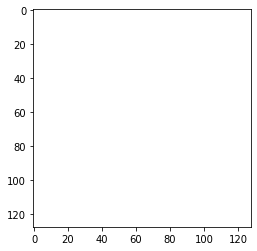

In [9]:
mean_images=(np.mean(np.array(image_array), axis=tuple(range(np.array(image_array).ndim-1))))
std_images=(np.std(np.array(image_array), axis=tuple(range(np.array(image_array).ndim-1))))
plt.imshow(X[105]*std_images+mean_images)


In [31]:

from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, ConvLSTM2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys
import logging
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


logger = logging.getLogger('Builder_moudle')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)


epoch = 10
learning_rate = 0.0004
batch_size = 16
optimizer ='RMSprop'
initial_weights = 'Xavier'

default_values = dict(epoch=10,\
                      learning_rate=0.0004,\
                      batch_size=16,\
                      optimizer='Adam',\
                      initial_weights=0,\
                      cnn_class=Xception,\
                      pre_weights='Xavier',\
                      dropout=0.5,\
                      lstm_conf=(LSTM,dict(units = 256)),\
                      cnn_train_type='static'
                      )


def build(epoch = default_values["epoch"],\
          learning_rate = default_values["learning_rate"], \
          batch_size = default_values["batch_size"],\
          optimizer = default_values["optimizer"],\
          initial_weights = default_values["initial_weights"],\
          cnn_class = default_values["cnn_class"],\
          pre_weights = default_values["pre_weights"], \
          dropout=default_values["dropout"], \
          lstm_conf = default_values["lstm_conf"], \
          cnn_train_type=default_values["cnn_train_type"]):

    model=0
    #Create CNN
    if(cnn_train_type!='train'):
        logger.info("CNN Created with Pre-weights:{}".format(pre_weights))
        base_model = cnn_class(weights=pre_weights,include_top=False)
    else:
        logger.info("CNN Created with no Pre-weights")
        base_model = cnn_class()

    #control Train_able of CNNN
    if(cnn_train_type=='static'):
        logger.info("CNN set to NOT-Train")
        for layer in base_model.layers:
            layer.trainable = False
    if(cnn_train_type=='retrain'):
        logger.info("CNN set to retrain")
        for layer in base_model.layers:
            layer.trainable = True

    # print(base_model.summary())
    # add a global spatial average pooling layer
    x = base_model.output
    logger.info("base_model.output: {}".format(base_model.output))
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

    model.summary()
    print("Commit update2")
    print("Commit update3")
    return model

In [11]:
figure_size = 128    v                                                               b                                          ./;/.;.l,;/l;lkjikjjik,kmjim,
# split_ratio = 0.1
batch_size = 2
# batch_epoch_ratio = 0.5 #double the size because we use augmentation
fix_len = 
initial_weights = 'glorot_uniform'
weights = 'imagenet'
force = True
lstm = (ConvLSTM2D, dict(filters=256, kernel_size=(3, 3), padding='same', return_sequences=False))
classes = 1

# hyper parameters for tunning the network
#cnns_arch = dict(ResNet50=ResNet50, InceptionV3=InceptionV3, VGG19=VGG19)  #
learning_rates = [1e-4, 1e-3]
use_augs = [True, False, ]
fix_lens = [20, 10]
optimizers = [(RMSprop, {}), (Adam, {})]
dropouts = [0.0, 0.5]
cnn_train_types = ['retrain', 'static']
model = build(size=128, seq_len=None, learning_rate=1e-3,
                                   optimizer_class=(Adam, {}), initial_weights=initial_weights,
                                   cnn_class=ResNet50, pre_weights=weights, lstm_conf=(ConvLSTM2D, dict(filters=256, kernel_size=(3, 3), padding='same', return_sequences=False)),
                                   cnn_train_type='retrain', dropout=0, classes=1)


SyntaxError: invalid syntax (<ipython-input-11-e6b1b4144f00>, line 1)

In [32]:
model=build(pre_weights='imagenet')

2019-12-08 19:33:33,775 - Builder_moudle - INFO - CNN Created with Pre-weights:imagenet
2019-12-08 19:33:33,775 - Builder_moudle - INFO - CNN Created with Pre-weights:imagenet
2019-12-08 19:33:37,094 - Builder_moudle - INFO - CNN set to NOT-Train
2019-12-08 19:33:37,094 - Builder_moudle - INFO - CNN set to NOT-Train
2019-12-08 19:33:37,100 - Builder_moudle - INFO - base_model.output: Tensor("block14_sepconv2_act_1/Identity:0", shape=(None, None, None, 2048), dtype=float32)
2019-12-08 19:33:37,100 - Builder_moudle - INFO - base_model.output: Tensor("block14_sepconv2_act_1/Identity:0", shape=(None, None, None, 2048), dtype=float32)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [33]:
# Store the fully connected layers
block14=model.layers[-4]
global_avg = model.layers[-3]
dense_2 = model.layers[-2]
predictions = model.layers[-1]

dropout1=Dropout (0.5)


# Reconnect the layers
x = dropout1(block14.output)
x=global_avg(x)
x = dense_2(x)
predictors = predictions(x)

# Create a new model
model2 = Model(inputs=model.input, outputs=predictors)
model2.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [34]:
history=model2.fit_generator(
    train_gen,
    steps_per_epoch=len(train_X) // batch_size,
    epochs=epoch,
    validation_data=valid_gen,
    validation_steps=len(valid_X) // batch_size,
    callbacks=[es])

model.save_weights('diff_with_dropout2_es.h5')

Epoch 1/10
8/8 [==============================] - 95s 12s/step - loss: 0.6708 - accuracy: 0.7718 - val_loss: 0.5387 - val_accuracy: 0.8824
Epoch 2/10
8/8 [==============================] - 93s 12s/step - loss: 0.3954 - accuracy: 0.8816 - val_loss: 0.4775 - val_accuracy: 0.8824
Epoch 3/10
8/8 [==============================] - 93s 12s/step - loss: 0.2953 - accuracy: 0.9015 - val_loss: 0.4214 - val_accuracy: 0.8824
Epoch 4/10
8/8 [==============================] - 93s 12s/step - loss: 0.3645 - accuracy: 0.8892 - val_loss: 0.3926 - val_accuracy: 0.8824
Epoch 5/10
8/8 [==============================] - 91s 11s/step - loss: 0.2267 - accuracy: 0.9176 - val_loss: 0.3734 - val_accuracy: 0.8824
Epoch 6/10
8/8 [==============================] - 91s 11s/step - loss: 0.2070 - accuracy: 0.9223 - val_loss: 0.3650 - val_accuracy: 0.8824
Epoch 7/10
8/8 [==============================] - 91s 11s/step - loss: 0.2769 - accuracy: 0.9148 - val_loss: 0.3653 - val_accuracy: 0.8824
Epoch 8/10
8/8 [===========

In [41]:
model2.evaluate(x=test_X, y=test_y)
from sklearn.metrics import classification_report

pred = model2.predict(test_X, batch_size=12, verbose=1)
predicted = (pred>0.92)
report = classification_report(test_y, predicted)
print(report)
print(test_y)
print(predicted)
print(pred)

42/42 [==============================] - 1s 27ms/sample
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.79      0.84      0.82        32

    accuracy                           0.71        42
   macro avg       0.58      0.57      0.58        42
weighted avg       0.69      0.71      0.70        42

[1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]]
[[0.92003405]
 [0.9205945 ]
 [0.9220243 ]
 [0.9206617 ]
 [0.9216537 ]
 [0.9253731 ]
 [0.92070997]
 [0.92391104]
 [0.91924036]
 [0.9205863 ]
 [0.9204882

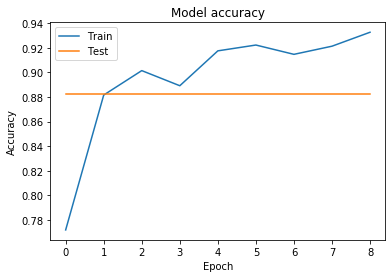

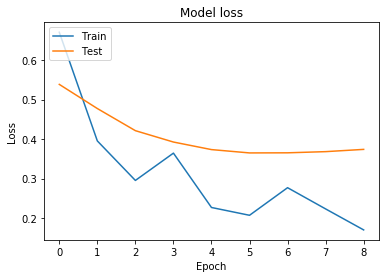

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, batch_size=2, verbose=0)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))


In [257]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.python.keras.utils.data_utils import Sequence
test_history = TestCallback((test_X, test_y))
patience_es=15
patience_lr=5
batch_size=2
generator=train_gen
validation_data=valid_gen
history = model.fit_generator(
    generator,
    steps_per_epoch=18,
    epochs=10,
    verbose=1,
    callbacks=None,
    validation_data=validation_data,
    validation_steps=len(valid_X)//batch_size,
    validation_freq=1,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)
                       
        

Epoch 1/10


ValueError: Error when checking input: expected input_13 to have 5 dimensions, but got array with shape (132, 128, 128, 3)